<a href="https://colab.research.google.com/github/santiviquez/noisy-human-recognition/blob/main/sound_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NN Experiments

## Dependencies

In [3]:
import os
import shutil
import urllib.request
import zipfile
import glob
import pandas as pd
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import librosa
import librosa.display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import svm
import xgboost as xgb
import time
import seaborn as sns

## Download Dataset

In [4]:
def download_dataset(name):
    """
    Download the dataset into current working directory.
    
    Originally taken from https://nbviewer.org/github/karoldvl/paper-2015-esc-dataset/blob/
    master/Notebook/ESC-Dataset-for-Environmental-Sound-Classification.ipynb#Setup
    Additional modifications were applied to make it work with Python 3
    """
    if not os.path.exists(name):
        os.mkdir(name)
        urllib.request.urlretrieve(f'https://github.com/karoldvl/{name}/archive/master.zip', f'{name}/{name}.zip')

        with zipfile.ZipFile(f'{name}/{name}.zip') as package:
            package.extractall(f'{name}/')

        os.unlink(f'{name}/{name}.zip')        

        for src in glob.glob(f'{name}/{name}-master/*'):
            shutil.move(src, '{0}/{1}'.format(name, os.path.basename(src)))

        shutil.rmtree(f'{name}/{name}-master')

download_dataset('ESC-50')

In [5]:
ls ESC-50

LICENSE           audio/            meta/             requirements.txt
README.md         esc50.gif         pytest.ini        tests/


## Sample Dataset: Non-Speech Human Sounds

In this project we are going to fucus at identifying non-speech human sounds. Such as: `crying_baby`, `sneezing`, `clapping`, etc. So we are going to filter these categories from the main esc50 dataset.

In [6]:
esc50 = pd.read_csv("ESC-50/meta/esc50.csv")

human_cats = ['crying_baby', 'sneezing', 'clapping', 
              'breathing', 'coughing', 'footsteps', 
              'laughing', 'brushing_teeth', 'snoring', 
              'drinking_sipping']

esc50_human = esc50[esc50["category"].isin(human_cats)].reset_index(drop=True)
esc50_human['old_target'] = esc50_human['target']

new_classes = [i for i in range(10)]
old_classes = esc50_human.target.drop_duplicates().values
map_old_new_classes = dict(zip(old_classes, new_classes))

#esc50_human = esc50[esc50["category"].isin(human_cats)].reset_index(drop=True)
#esc50_human['old_target'] = esc50_human['target']
esc50_human = esc50_human.replace({"target": map_old_new_classes})

In [7]:
esc50_human.head()

,filename,fold,target,category,esc10,src_file,take,old_target
0,1-104089-A-22.wav,1,0,clapping,False,104089,A,22
1,1-104089-B-22.wav,1,0,clapping,False,104089,B,22
2,1-105224-A-22.wav,1,0,clapping,False,105224,A,22
3,1-110537-A-22.wav,1,0,clapping,False,110537,A,22
4,1-115920-A-22.wav,1,0,clapping,False,115920,A,22


`X_train` has a shape of `(320, 13, 431)` meaning that we have 320 examples of shape `(13, 431)` we can think about each example as an image of that size.

## Data Preparation for NN

In [8]:
%pip install torchaudio_augmentations # for google-colab
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as transforms
import torchaudio
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from torchaudio_augmentations import Compose, ComposeMany, Noise, Gain, PolarityInversion, Delay, HighLowPass, RandomApply

# Avoiding nondeterministic algorithms for reproducibility purposes
torch.use_deterministic_algorithms(False)
random.seed(0)
np.random.seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Note: you may need to restart the kernel to use updated packages.


In [9]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)
torch.manual_seed(42)

In [10]:
def get_dataloader_dict(df):
    dataloader_dict = {}
    for i, row in df.iterrows():  
        filename = row["filename"]
        fold = int(row["fold"])
        target = row["target"]
        category = row["category"]
        
        waveform, sample_rate = torchaudio.load("ESC-50/audio/" + filename, normalize=True)
        dataloader_dict[i] = {"filename":filename, "data":waveform, "target":target, "category":category,"fold":fold}
    return dataloader_dict

In [11]:
def train_val_loader(dic, fold):
    X_val = []
    X_train = []
    y_val = []
    y_train = []

    for id, subj in dic.items():

        if subj["fold"]!=fold:
            X_train.append(subj['data'])
            y_train.append(subj['target'])
                
        if subj["fold"]==fold:
            X_val.append(subj['data'])
            y_val.append(subj['target'])
    
    return X_train, np.array(y_train), X_val, np.array(y_val)

In [12]:
class ESCHDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)        
        return x, y
    
    def __len__(self):
        return len(self.data)

## Training Functions

In [13]:
# Function to save the model - best model in terms of validation accuracy
def save_model(model, model_name): 
    path = f"./models/{model_name}_.pth" 
    torch.save(model.state_dict(), path)

In [14]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        # print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

In [15]:
# Class oringinally taken from https://stackoverflow.com/a/73704579
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [16]:
def train(num_epochs, training_loader, validation_loader, model, model_name_fold, is_augmented):
    best_accuracy_value = 0.0
    train_loss_list = []
    val_loss_list = []
    early_stopper = EarlyStopper(patience=10, min_delta=0.1)

    
    print("Begin Training")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
        total = 0

        # training loop
        model.train()
        for i, data in enumerate(training_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            if is_augmented == True:
                inputs = torch.flatten(inputs, start_dim=0, end_dim=1)
                labels = labels.repeat(5)
            #labels = labels.to(torch.long)
            #inputs = inputs.to(torch.float32)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            train_loss.backward()
            optimizer.step()

            # track train loss
            running_train_loss += train_loss.item()
            # make predictions on training data
            _, train_preds = torch.max(outputs, 1)
            # track train f1-score
            running_train_accuracy += accuracy_score(labels.cpu(), train_preds.cpu())

        # calculate train loss and train accuracy values
        train_loss_value = running_train_loss / len(training_loader)
        train_accuracy_value = running_train_accuracy / len(training_loader)

        # validation loop
        model.eval()
        with torch.no_grad():
            for data in validation_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                _, val_preds = torch.max(outputs, 1)
                running_val_loss += val_loss.item()
                total += outputs.size(0)
                running_val_accuracy += accuracy_score(labels.cpu(), val_preds.cpu()) 
        
        # calculate val loss and val f1-score values
        val_loss_value = running_val_loss / len(validation_loader)
        val_accuracy_value = running_val_accuracy / len(validation_loader)
        
        # call lr scheduler
        scheduler.step(val_loss_value)
        print(f"Current lr:{scheduler.optimizer.param_groups[0]['lr']}")

        # Save model is val f1-score is the best
        if val_accuracy_value > best_accuracy_value:
            save_model(model, model_name_fold)
            best_accuracy_value = val_accuracy_value

        # Print the statistics of the epoch 
        train_loss_list.append(train_loss_value)
        val_loss_list.append(val_loss_value)
        
        # print(f'Current lr: {optimizer.param_groups[0]["lr"]}')
        print('Completed training batch', epoch, 'Train Loss: %.4f' %train_loss_value, 
              'Val Loss: %.4f' %val_loss_value, 'Train Accuracy: %.4f' %train_accuracy_value, 
              'Val Accuracy: %.4f' %val_accuracy_value)
        
        # stop if val loss has no t decreased in the last (# of patience) epochs
        if early_stopper.early_stop(val_loss_value):
            print("Early Stopping")
            break

    print('Finished Training')
    
    # plot loss for training and validation for the current batch
    plt.plot(train_loss_list[0:-1])
    plt.plot(val_loss_list[0:-1])
    plt.show()
    
    # pass back the accuracy from the best model
    return train_loss_list, val_loss_list, best_accuracy_value

In [17]:
# function for cross-validation
def train_cv(num_epochs, df, model, model_name, transformations, is_augmented=False, n_folds=5):
    '''
    Inputs required/define:
    - number of training epochs (num_epochs) per fold
    - df is input data
    - n_folds - use 5-fold cross-validation
    - model is the defined model we use for training and validation
    - model_name asks for how to save the model
    - transformations is a torch.Compose object computing MFCCs / or also augmentations
    '''
    # to store loss and accuracy of each fold
    train_losses = {}
    val_losses = {}
    batch_times = []
    accuracies = []
    
    # open data
    dataloader_dic = get_dataloader_dict(df)
    
    for i in range(1, n_folds+1):
        # reset model weights to avoid weights leakage between folds
        model.apply(reset_weights)
        
        print(f'FOLD # {i}')
        model_name_fold = str(model_name) + '_fold_' + str(i)
        training_start_time = time.time()
        
        X_train, y_train, X_val, y_val = train_val_loader(dataloader_dic, fold=i)
        
        train_dataset = ESCHDataset(X_train, y_train, transform=transformations)
        train_loader = DataLoader(train_dataset, batch_size=80, drop_last=True,
                                 worker_init_fn=seed_worker, 
                                 generator=g)
        val_dataset = ESCHDataset(X_val, y_val, transform=transform_mfcc)
        val_loader = DataLoader(val_dataset, batch_size=80, drop_last=True,
                                 worker_init_fn=seed_worker, 
                                 generator=g)
        
        # train for current fold of data
        # train(num_epochs, training_loader, validation_loader, model, model_name_fold)
        train_loss_fold, val_loss_fold, best_accuracy = train(num_epochs, 
                                                              train_loader, 
                                                              val_loader, 
                                                              model, 
                                                              model_name_fold,
                                                              is_augmented)
        
        # stop time and print total fold runtime 
        training_stop_time = time.time()
        batch_runtime = training_stop_time - training_start_time
        batch_times.append(batch_runtime)
        
        print(f'Fold {i} runtime: {batch_runtime}')
        
        # plot loss for training and validation
        #plt.plot(train_loss_fold[0:-1])
        #plt.plot(val_loss_fold[0:-1])
        
        # save loss and acc in dictionary for later prediction and comparison
        train_losses[i] = train_loss_fold
        val_losses[i] = val_loss_fold
        
        # at the end of every fold, appemd the best accuracy 
        accuracies.append(best_accuracy)
      

    mean_acc = sum(accuracies)/len(accuracies) # and then return the average over the best models for each fold
    
    return train_losses, val_losses, batch_times, mean_acc

## Experiments

In [18]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(4, 4), stride=1)
        self.bn1 = nn.BatchNorm2d(1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=1070, out_features=420)
        self.fc2 = nn.Linear(in_features=420, out_features=10)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

### Simple CNN - Without Data Augmentation

In [20]:
RATE = 44100
transform_mfcc = transforms.MFCC(sample_rate=RATE, 
                     n_mfcc=13,
                     melkwargs={"n_fft": 2048, "hop_length": 512, "n_mels": 60})

cuda
FOLD # 1
Begin Training
Completed training batch 0 Train Loss: 2.2307 Val Loss: 2.1187 Train Accuracy: 0.1406 Val Accuracy: 0.2375
Completed training batch 1 Train Loss: 1.9777 Val Loss: 2.1498 Train Accuracy: 0.2969 Val Accuracy: 0.2750
Completed training batch 2 Train Loss: 1.8021 Val Loss: 2.0883 Train Accuracy: 0.3781 Val Accuracy: 0.2750
Completed training batch 3 Train Loss: 1.6572 Val Loss: 2.1633 Train Accuracy: 0.4906 Val Accuracy: 0.2625
Completed training batch 4 Train Loss: 1.5616 Val Loss: 2.0853 Train Accuracy: 0.4812 Val Accuracy: 0.2500
Completed training batch 5 Train Loss: 1.4469 Val Loss: 2.0924 Train Accuracy: 0.5594 Val Accuracy: 0.2750
Completed training batch 6 Train Loss: 1.3512 Val Loss: 2.0602 Train Accuracy: 0.5875 Val Accuracy: 0.2625
Completed training batch 7 Train Loss: 1.2505 Val Loss: 2.0570 Train Accuracy: 0.6313 Val Accuracy: 0.2750
Completed training batch 8 Train Loss: 1.1586 Val Loss: 2.0539 Train Accuracy: 0.6656 Val Accuracy: 0.2875
Complete

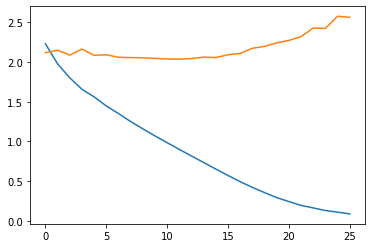

Fold 1 runtime: 43.729655265808105
FOLD # 2
Begin Training
Completed training batch 0 Train Loss: 2.2032 Val Loss: 2.1244 Train Accuracy: 0.1281 Val Accuracy: 0.2750
Completed training batch 1 Train Loss: 1.8201 Val Loss: 2.0738 Train Accuracy: 0.3625 Val Accuracy: 0.3000
Completed training batch 2 Train Loss: 1.5483 Val Loss: 2.0122 Train Accuracy: 0.4844 Val Accuracy: 0.3000
Completed training batch 3 Train Loss: 1.3266 Val Loss: 2.0253 Train Accuracy: 0.5625 Val Accuracy: 0.3125
Completed training batch 4 Train Loss: 1.1387 Val Loss: 2.0581 Train Accuracy: 0.6719 Val Accuracy: 0.3125
Completed training batch 5 Train Loss: 0.9619 Val Loss: 2.0566 Train Accuracy: 0.7594 Val Accuracy: 0.3375
Completed training batch 6 Train Loss: 0.8240 Val Loss: 2.1389 Train Accuracy: 0.7875 Val Accuracy: 0.3375
Completed training batch 7 Train Loss: 0.6835 Val Loss: 2.1371 Train Accuracy: 0.8500 Val Accuracy: 0.3625
Completed training batch 8 Train Loss: 0.5617 Val Loss: 2.2367 Train Accuracy: 0.8938

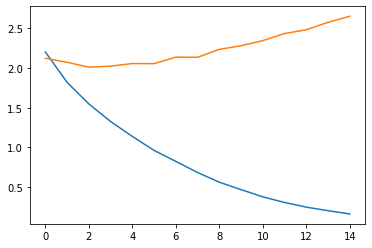

Fold 2 runtime: 26.09545636177063
FOLD # 3
Begin Training
Completed training batch 0 Train Loss: 2.2503 Val Loss: 2.1127 Train Accuracy: 0.1562 Val Accuracy: 0.1625
Completed training batch 1 Train Loss: 1.8911 Val Loss: 2.0097 Train Accuracy: 0.3500 Val Accuracy: 0.3375
Completed training batch 2 Train Loss: 1.5253 Val Loss: 1.9959 Train Accuracy: 0.5219 Val Accuracy: 0.3500
Completed training batch 3 Train Loss: 1.2259 Val Loss: 2.0316 Train Accuracy: 0.6156 Val Accuracy: 0.3000
Completed training batch 4 Train Loss: 0.9588 Val Loss: 2.0386 Train Accuracy: 0.7156 Val Accuracy: 0.3250
Completed training batch 5 Train Loss: 0.7251 Val Loss: 2.0160 Train Accuracy: 0.8156 Val Accuracy: 0.3000
Completed training batch 6 Train Loss: 0.5350 Val Loss: 2.0280 Train Accuracy: 0.8906 Val Accuracy: 0.3000
Completed training batch 7 Train Loss: 0.3967 Val Loss: 2.0786 Train Accuracy: 0.9469 Val Accuracy: 0.3125
Completed training batch 8 Train Loss: 0.2852 Val Loss: 2.1528 Train Accuracy: 0.9656 

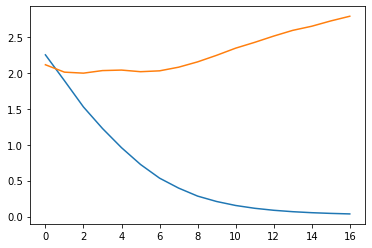

Fold 3 runtime: 28.355194330215454
FOLD # 4
Begin Training
Completed training batch 0 Train Loss: 2.2439 Val Loss: 2.0512 Train Accuracy: 0.1406 Val Accuracy: 0.2250
Completed training batch 1 Train Loss: 2.0089 Val Loss: 2.0651 Train Accuracy: 0.3063 Val Accuracy: 0.2750
Completed training batch 2 Train Loss: 1.9061 Val Loss: 2.0013 Train Accuracy: 0.3312 Val Accuracy: 0.2625
Completed training batch 3 Train Loss: 1.8012 Val Loss: 1.9673 Train Accuracy: 0.3906 Val Accuracy: 0.2875
Completed training batch 4 Train Loss: 1.6934 Val Loss: 1.9764 Train Accuracy: 0.4437 Val Accuracy: 0.2875
Completed training batch 5 Train Loss: 1.5744 Val Loss: 1.9309 Train Accuracy: 0.4844 Val Accuracy: 0.3000
Completed training batch 6 Train Loss: 1.4646 Val Loss: 1.9250 Train Accuracy: 0.5125 Val Accuracy: 0.2875
Completed training batch 7 Train Loss: 1.3763 Val Loss: 1.9531 Train Accuracy: 0.5687 Val Accuracy: 0.2875
Completed training batch 8 Train Loss: 1.2886 Val Loss: 1.9770 Train Accuracy: 0.5781

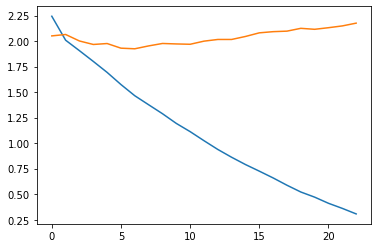

Fold 4 runtime: 38.64576745033264
FOLD # 5
Begin Training
Completed training batch 0 Train Loss: 2.2177 Val Loss: 2.2835 Train Accuracy: 0.1656 Val Accuracy: 0.1375
Completed training batch 1 Train Loss: 1.9396 Val Loss: 2.2202 Train Accuracy: 0.2844 Val Accuracy: 0.1750
Completed training batch 2 Train Loss: 1.7564 Val Loss: 2.1665 Train Accuracy: 0.4219 Val Accuracy: 0.2500
Completed training batch 3 Train Loss: 1.6023 Val Loss: 2.0804 Train Accuracy: 0.5062 Val Accuracy: 0.2875
Completed training batch 4 Train Loss: 1.4525 Val Loss: 2.0437 Train Accuracy: 0.5563 Val Accuracy: 0.3000
Completed training batch 5 Train Loss: 1.3130 Val Loss: 2.0339 Train Accuracy: 0.5969 Val Accuracy: 0.3500
Completed training batch 6 Train Loss: 1.2097 Val Loss: 2.0756 Train Accuracy: 0.6344 Val Accuracy: 0.3000
Completed training batch 7 Train Loss: 1.0904 Val Loss: 2.1037 Train Accuracy: 0.6813 Val Accuracy: 0.3375
Completed training batch 8 Train Loss: 0.9958 Val Loss: 2.1439 Train Accuracy: 0.7281 

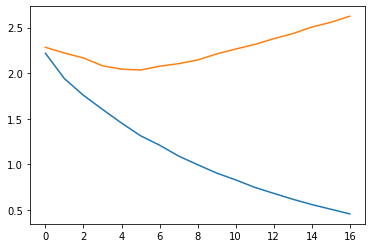

Fold 5 runtime: 28.60686731338501


In [ ]:
net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

net.to(device)
print(device)

# the train_cv function needs (num_epochs, df, model, model_name, transformations, n_folds = 5)
name = 'CNN_MFCC_baseline_run3'
train_loss_dict, val_loss_dict, batch_runtimes, mean_accuracy = train_cv(100, esc50_human, net, name, transform_mfcc)

In [ ]:
# show mean validation accuracy over all folds and best epochs
print(f"Mean runtime per fold (s): {np.round(np.mean(batch_runtimes))}")
print(f"Mean val accuracy: {np.round(mean_accuracy, 2)}")

Mean runtime per fold (s): 33.0
Mean val accuracy: 0.37


### Simple CNN - With Data Augmentation

In [23]:
transform = ComposeMany(
    [
        RandomApply([Noise(min_snr=0.01, max_snr=0.05)], p=0.5),
        RandomApply([HighLowPass(sample_rate=RATE)], p=0.5),
        RandomApply([Delay(sample_rate=RATE, min_delay=50, max_delay=55)], p=0.5),
        transforms.MFCC(sample_rate=RATE, 
                     n_mfcc=13, 
                     melkwargs={"n_fft": 2048, "hop_length": 512, "n_mels": 60})
    ], num_augmented_samples=5)

net = CNN()
net.to(device)
print(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)
# the train_cv function needs (num_epochs, df, model, model_name, transformations, n_folds = 5)
name = 'CNN_MFCC_augmented'
train_loss_dict, val_loss_dict, batch_runtimes, mean_accuracy = train_cv(100, 
                                                                         esc50_human, 
                                                                         net,
                                                                         name, 
                                                                         transform, 
                                                                         is_augmented=True)

cpu
FOLD # 1
Begin Training
Current lr:0.001
Completed training batch 0 Train Loss: 2.3378 Val Loss: 2.3092 Train Accuracy: 0.1075 Val Accuracy: 0.1000



KeyboardInterrupt



In [ ]:
# show mean validation accuracy over all folds and best epochs
print(f"Mean runtime per fold (s): {np.round(np.mean(batch_runtimes))}")
print(f"Mean val accuracy: {np.round(mean_accuracy, 2)}")